In [72]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                            mean_absolute_percentage_error, roc_auc_score, precision_score, recall_score)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
plt.style.use('classic')

import multiprocessing

import warnings
warnings.filterwarnings("ignore")

---
### Задача

Набор данных суперсимметрии поддерживает двоичную классификацию событий столкновений в физике элементарных частиц на основе собранных особенностей столкновений. Вам будет необходимо научиться предсказывать вид события в зависимости от физических параметров частиц после столкновения.

Данные состоят из следующих функций:

- `target class` : метки классов, где 0 - фоновое событие, 1 - суперсимметричное событие.
- `L1pT` : импульс, поперечный лучу лептона 1
- `L1eta` : псевдобыстрота лептона 1
- `L1phi` : азимутальный угол лептона 1
- `L2pT` : импульс, поперечный лучу лептона 2
- `L2eta` : псевдобыстрота лептона 2
- `L2phi` : азимутальный угол лептона 2
- `missing energy magnitude` : количество недостающего поперечного импульса
- `missing energy phi` : азимутальный угол недостающего поперечного импульса
Остальные 10 признаков получены из первых 8 непосредственно измеренных признаков. Эти последние 10 функций — это функции, которые физики элементарных частиц разработали для улучшения своей задачи по обнаружению событий. Подробнее про оригинальное исследование можете посмотреть в прикрепленной статье.

Суперсимметрия — это теоретическая основа физики элементарных частиц, которая предлагает принцип симметрии, связывающий фермионы (частицы с полуцелым спином) и бозоны (частицы с целым спином). Эта инновационная теория вводит концепцию суперсимметричного партнера для каждой известной элементарной частицы, которая отличается по спину на 1/2, но имеет другие фундаментальные свойства, такие как заряд и масса.

---

Данное домашнее задание имеет свободную форму, то есть вашей задачей будет для каждого класса моделей получить лучший результат и после выбрать наилучшую модель. Метрика для задачи - `from sklearn.metrics import f1_score`. Работа будет оцениваться по следующим ключевым пунктам:


1.   Предвартельный анализ данных
2.   Предобработка данных
      -   Обработка пропусков
      -   Обработка выбросов

3.   Реализация моделей
      -  Дерево
      -  Логистическая регрессия
      -  KNN



#### 1. Предварительный анализ данных

В этом разделе ожидается, что вы посмотрите на распределение признаков и классов, изучите их связь, проанализируете признаки на наличие в них пропусков или выбросов.

In [2]:
df = pd.read_csv('hw5_phds_phys_data.csv')
df.head()

,target class,L1pT,L1eta,L1phi,L2pT,L2eta,L2phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.712592,0.776299,-0.977246,0.775582,0.546116,0.622289,0.282914,-0.637910,0.240377,0.594836,0.618827,0.399519,0.572907,0.000000,0.602655,0.057377,1.006094,0.005815
1,0.0,1.892328,-0.483967,0.856761,1.583623,0.419065,-1.217196,0.450840,-0.720053,0.525133,-0.129555,1.681192,1.076764,0.568355,1.079640,1.620158,1.083848,0.085631,0.200274
2,0.0,0.794814,-0.449250,-0.442333,0.661218,0.421613,0.360242,1.526186,-1.558715,0.622938,-0.883875,0.698650,1.359658,1.726974,2.710943,0.811192,2.078608,1.187547,0.222146
3,0.0,1.022095,-1.819581,-1.527694,1.699453,-0.942580,-0.161568,0.766020,1.256380,1.092142,-0.286909,1.203704,1.112944,0.820481,1.593700,1.216380,1.201468,0.990246,0.094413
4,0.0,1.101241,-1.554862,0.663383,0.738752,1.810270,-0.956134,0.673655,-0.281957,0.945816,0.303187,2.818509,0.813961,0.256272,0.000000,2.819245,0.869279,0.848179,0.022044


In [3]:
df.describe()

,target class,L1pT,L1eta,L1phi,L2pT,L2eta,L2phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
count,300000.000000,270281.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,269976.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,3.000000e+05
mean,0.180617,0.806139,0.002342,-0.000382,0.931421,0.000674,0.004912,317.168176,0.001730,0.860035,-0.040169,0.909393,0.817755,0.968453,0.960499,0.912953,0.904408,0.990965,1.948868e-01
std,0.384701,0.505175,1.065371,1.003194,0.594539,1.054132,1.000748,2588.677366,1.001141,0.709926,0.732149,0.590783,0.407698,0.456871,0.786147,0.586717,0.557254,0.439444,1.770440e-01
min,0.000000,0.174402,-2.102801,-1.734789,0.428588,-2.059306,-1.734191,0.000720,-1.727112,0.000002,-9.570613,0.268493,0.006116,0.004674,0.000000,0.070768,0.004469,0.000016,1.498080e-07
25%,0.000000,0.506473,-0.837815,-0.868827,0.580922,-0.839517,-0.860624,0.420215,-0.864875,0.336958,-0.419683,0.540338,0.554099,0.625706,0.236615,0.551977,0.464411,0.670773,5.840420e-02
50%,0.000000,0.666549,0.003970,-0.005246,0.756538,0.001746,0.006563,0.665882,-0.006544,0.721962,-0.071250,0.739655,0.758104,0.903043,0.887005,0.748899,0.833992,1.084147,1.415535e-01
75%,0.000000,0.930683,0.842544,0.869711,1.062191,0.841115,0.872264,0.985724,0.870794,1.210727,0.280208,1.080284,0.996576,1.248131,1.531923,1.082994,1.264635,1.365324,2.818647e-01
max,1.000000,11.278777,2.101538,1.734833,16.929445,2.059696,1.734686,21999.968204,1.740689,12.754412,18.428970,14.689141,8.675550,4.819176,11.615088,14.734563,8.950393,1.591660,9.892850e-01


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   target class              300000 non-null  float64
 1   L1pT                      270281 non-null  float64
 2   L1eta                     300000 non-null  float64
 3   L1phi                     300000 non-null  float64
 4   L2pT                      300000 non-null  float64
 5   L2eta                     300000 non-null  float64
 6   L2phi                     300000 non-null  float64
 7   missing energy magnitude  300000 non-null  float64
 8   missing energy phi        300000 non-null  float64
 9   MET_rel                   300000 non-null  float64
 10  axial MET                 300000 non-null  float64
 11  M_R                       300000 non-null  float64
 12  M_TR_2                    269976 non-null  float64
 13  R                         300000 non-null  f

**Пропуски**

Тут уже видно, что пропуски у нас есть только в признаках L1pT и M_TR_2, но можно и картинку построить:

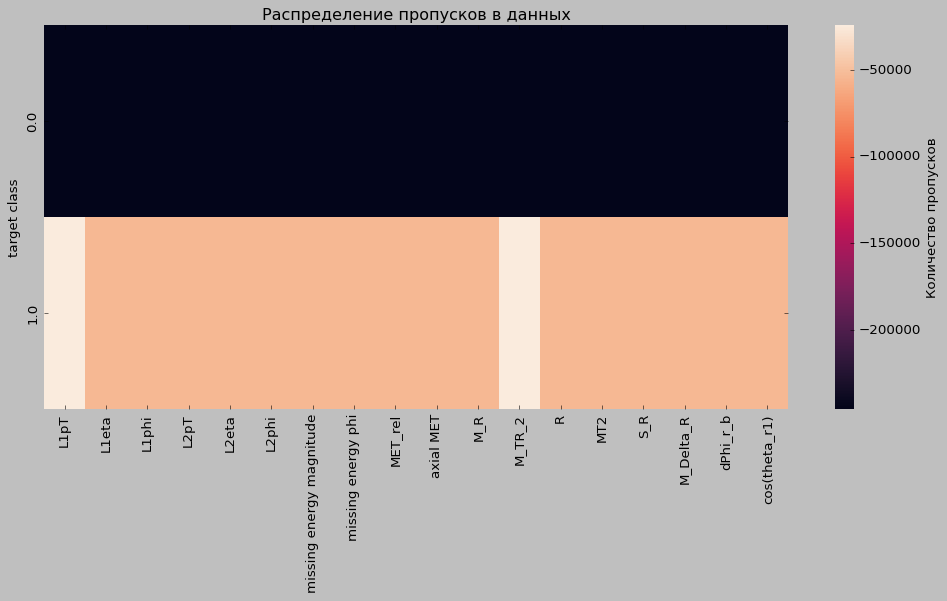

In [5]:
df_groupped = df.groupby("target class").count()
plt.figure(figsize=(15, 6))

# Обычно смотрят не на количество записей, а на количество пропущенных ячеек
sns.heatmap(
    len(df["target class"].unique()) - df_groupped.iloc[:, :],
    cbar_kws={"label": "Количество пропусков"},
)
plt.title("Распределение пропусков в данных");

Интересно, что пропуски находятся только у представителей первого класса.

**Выбросы**

При первой попытке построить boxplot было обнаружено, что диапазон значений признака missing energy magnitude сильно более обширный, чем у остальных признаков, из-за чего на общем графике ничего становится не видно. Поэтому, этот признаков вынесем в отдельный ящик с усами:

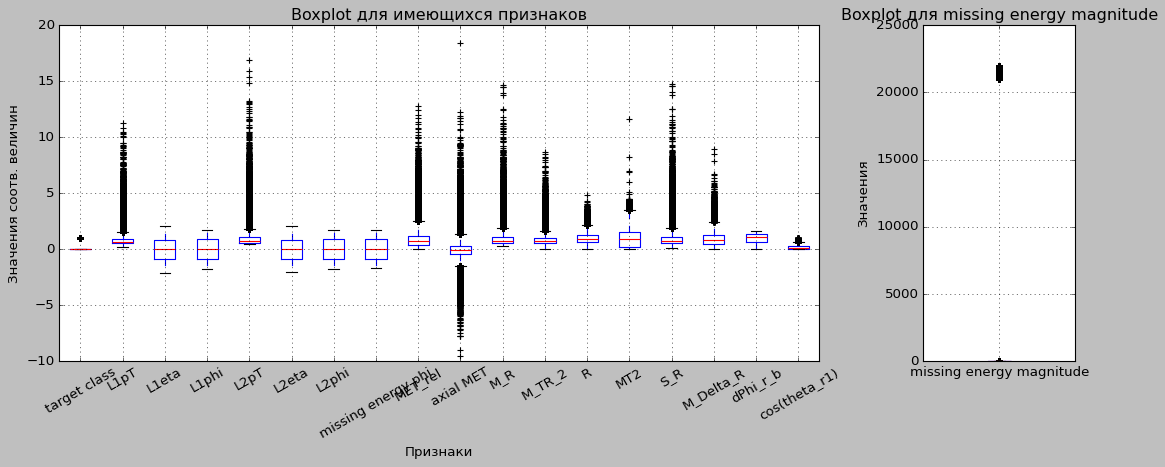

In [6]:
cols = list(df.columns.copy())
cols.remove('missing energy magnitude')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6),
                              gridspec_kw={'width_ratios': [5, 1]})

# Остальной код такой же как выше
df.boxplot(column=cols, ax=ax1, rot=30)
ax1.set_xlabel('Признаки')
ax1.set_ylabel('Значения соотв. величин')
ax1.set_title('Boxplot для имеющихся признаков')

df.boxplot(column=['missing energy magnitude'], ax=ax2, rot=0)
ax2.set_title('Boxplot для missing energy magnitude')
ax2.set_ylabel('Значения')

plt.tight_layout()
plt.show()

Видим, что почти у всех признаков есть выбросы.

**Корреляция**

Построим матрицу корреляции, которая поможет выявить совпадающие столбцы и/или зависимые признаки, чтобы в будущем об этом знать.

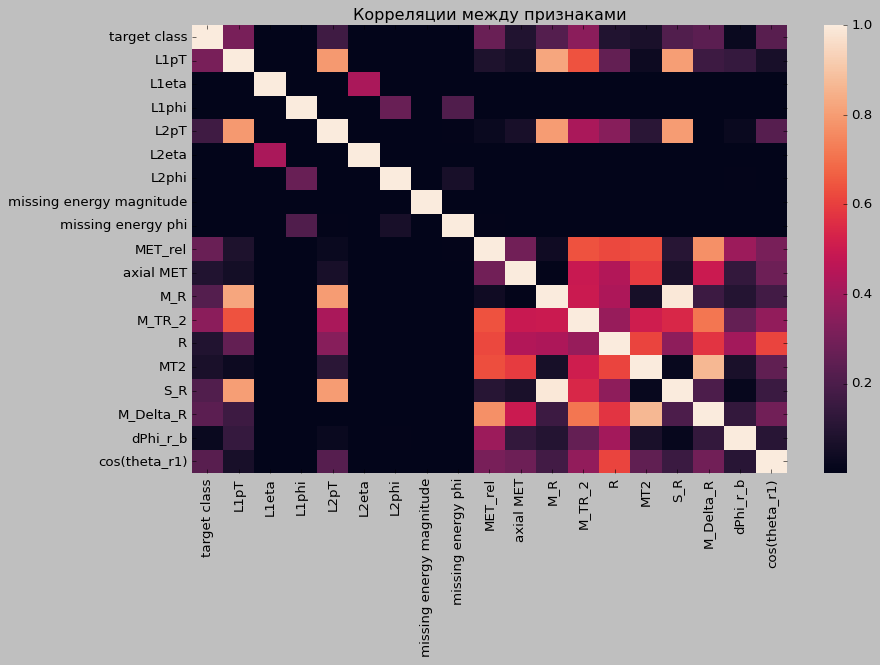

In [7]:
corr_matrix = (
    df.corr().abs()
)

plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix).set(title="Корреляции между признаками");

Судя по матрице, есть довольно сильно коррелирующие признаки.
В частности:
1. Очень сильно коррелируют:
   - M_R и S_R
3. Сильно коррелируют:
   - L1pT и L2pT
   - L1pT и M_R
   - L1pT и S_R
   - L2pT и M_R
   - L2pT и S_R
Очень странной мне кажется корреляция между импульсами двух различных лептонов, но, вероятно, тут вступают в игру какие-то законы квантовой механики.

На всякий случай проверила, не совпадают ли столбцы M_R и S_R, но по df.describe() видно, что характеристики столбцов всё же немного отличаются, т.е. полного соответствия нет.

**Гистограммы и KDE**

Также построим гистограммы распределений по признакам, а также графики их ядерной оценки плотности:

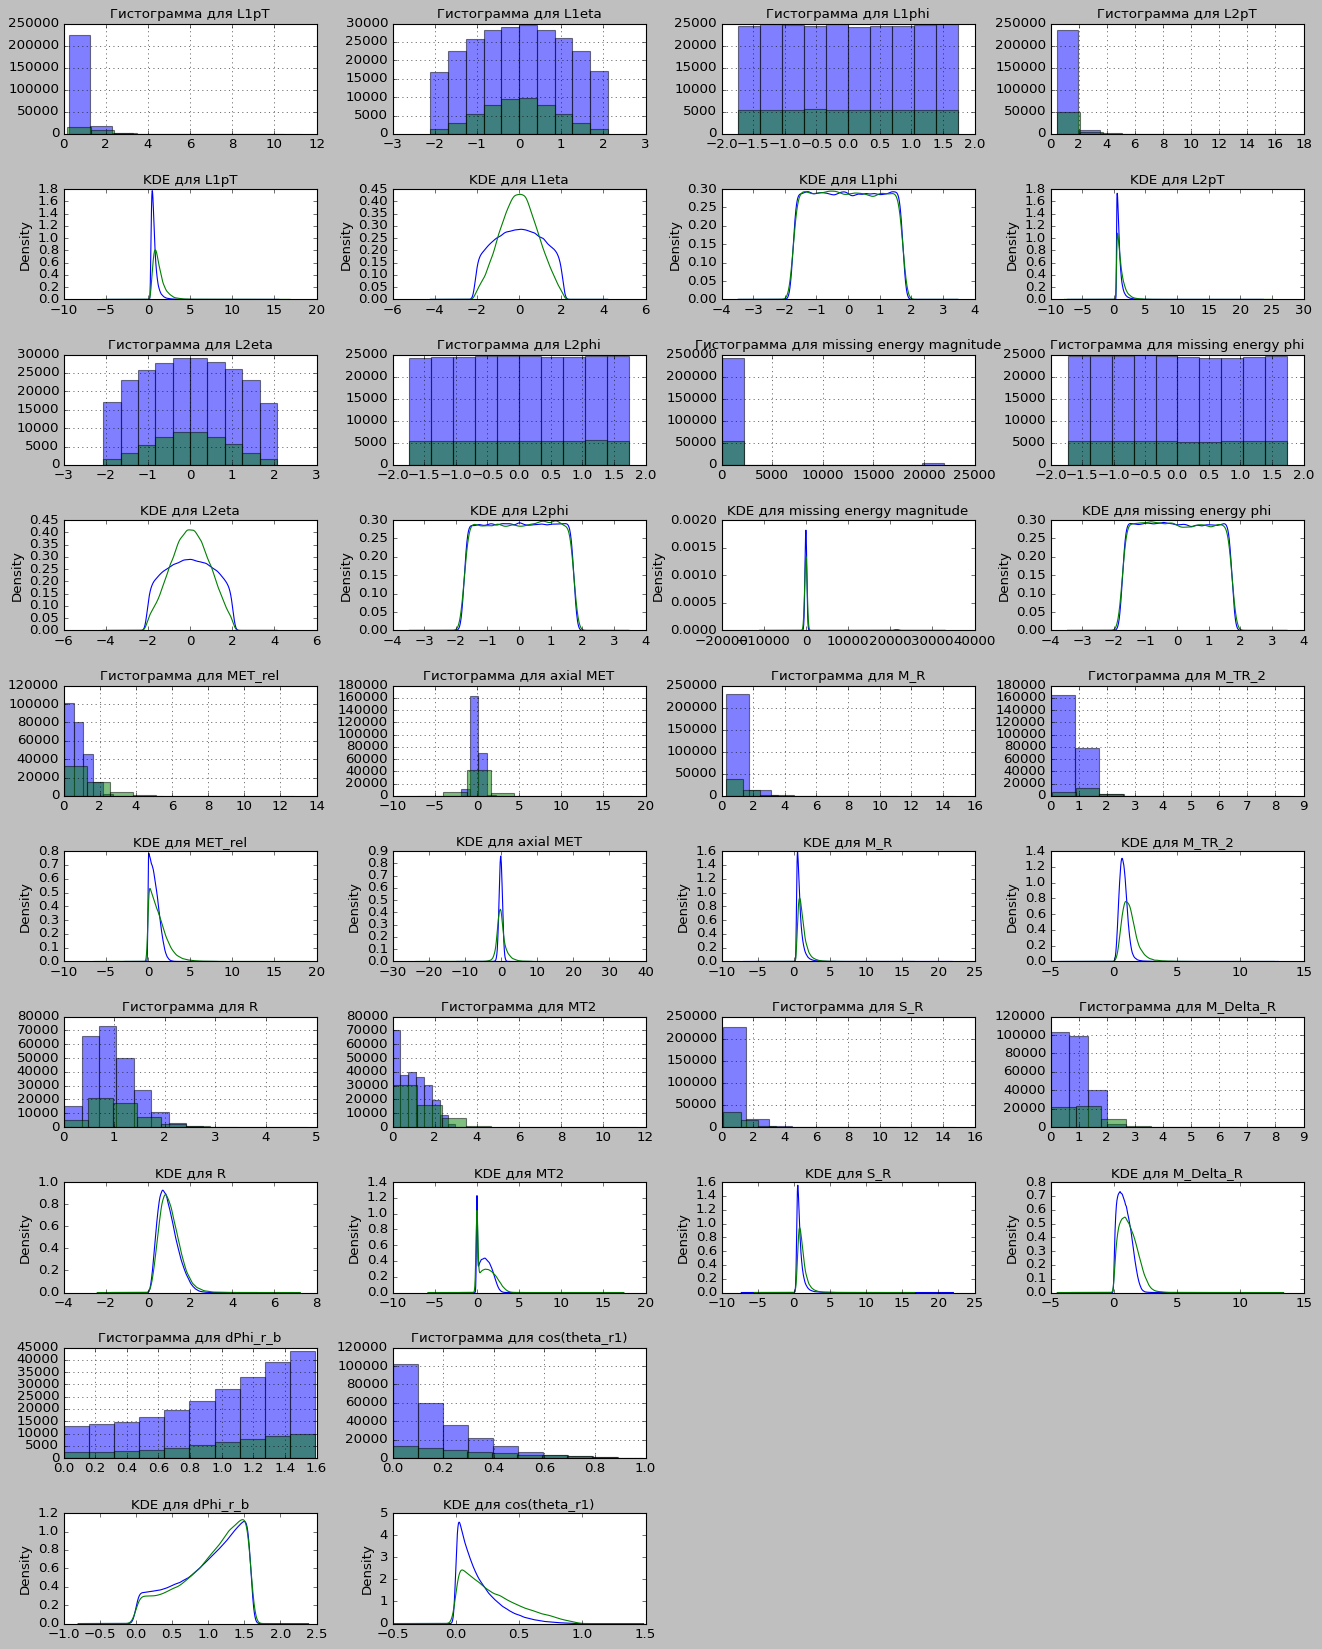

In [8]:
# Получаем список всех признаков (исключая "target class" если он есть)
features = [col for col in df.columns if col != "target class"]
num_features = len(features)

# Рассчитываем количество строк для 4 графиков в строке
num_rows = (num_features + 3) // 4  # Округление вверх

# Создаем фигуру с нужным количеством строк и 4 столбцами (2 графика на признак)
fig, axs = plt.subplots(num_rows * 2, 4, figsize=(20, 5 * num_rows))

# Делаем отступы между графиками
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Проходим по всем признакам и строим графики
for i, feature in enumerate(features):
    row_idx = (i // 4) * 2
    col_idx = i % 4
    
    # Гистограмма
    df.groupby("target class")[feature].hist(ax=axs[row_idx, col_idx], alpha=0.5)
    axs[row_idx, col_idx].set_title(f'Гистограмма для {feature}', fontsize=12)
    
    # KDE plot
    df.groupby("target class")[feature].plot(kind='kde', ax=axs[row_idx+1, col_idx])
    axs[row_idx+1, col_idx].set_title(f'KDE для {feature}', fontsize=12)

# Скрываем пустые subplots, если количество признаков не кратно 4
for i in range(num_features, num_rows * 4):
    row_idx = (i // 4) * 2
    col_idx = i % 4
    axs[row_idx, col_idx].axis('off')
    axs[row_idx+1, col_idx].axis('off')

plt.show()

Видим, что нет признаков, по которым сразу можно различить представителей классов. Также, на некоторых признаков подтвердилось наличие выбросов (есть длинные "хвосты" у распределений).

**Выводы:**
1. Пропуски есть только в столбцах L1pT и M_TR_2. Интересно заметить, что только у представителей 1-го класса.
2. Выбросы есть почти у всех признаков. Нет их у столбцов L1eta, L1phi, L2eta, L2phi, missing energy phi, dPhi_r_b, что логично, учитывая, что это всё значения углов, а они могут принимать ограниченный набор значений (скорее всего используются углы не больше 360 или какого-то другого значения).
3. Есть сильно коррелирующие признаки. Скорее всего, для лог.регрессии понадобится регуляризация.
4. Нет категориальных признаков. OneHotEncoder и т.д. не понадобятся.
5. Диапазоны значений признаков достаточно различны. Нужно будет применить стандартизацию для моделей, чувствительных к масштабу признаков.

#### 2. Предобработка данных

В этом разделе ожидается, что вы обработаете пропуски (если они есть) с помощью линейной регрессии, а выбросы (если они есть) обработайте способом на ваше усмотрение. Для оценки качества обработки пропусков используйте метрику MAPE.

In [9]:
X, y = df[df.columns[1:]], df[df.columns[0]]

**Пропуски**

In [10]:
X.isna().sum()

L1pT                        29719
L1eta                           0
L1phi                           0
L2pT                            0
L2eta                           0
L2phi                           0
missing energy magnitude        0
missing energy phi              0
MET_rel                         0
axial MET                       0
M_R                             0
M_TR_2                      30024
R                               0
MT2                             0
S_R                             0
M_Delta_R                       0
dPhi_r_b                        0
cos(theta_r1)                   0
dtype: int64

Для работы с линейной регрессией лучше стандартизовать данные. При этом при обучении моделей нужно будет обучать Scaler только на трейновой части данных. Поэтому:
1. Стандартизируем весь датасет
2. Заполняем пропуски
3. Возвращаемся в первоначальный масштаб
4. Делим данные на трейн и тест
5. Проводим дальнейшее обучение моделей

In [11]:
known_columns = list(X.columns)
known_columns.remove('L1pT')
known_columns.remove('M_TR_2')
unknown_columns = ['L1pT', 'M_TR_2']
len(known_columns)

16

In [12]:
# Исходные данные (копируем, чтобы не менять исходный DataFrame)
temp_X = X.copy()

# 1. Разделяем данные на known/unknown ПЕРЕД стандартизацией
mask = temp_X[unknown_columns].isna().any(axis=1)
known = temp_X[~mask].copy()  # Строки БЕЗ пропусков в unknown_columns
unknown = temp_X[mask].copy() # Строки С пропусками в unknown_columns

# 2. Стандартизируем known_columns ТОЛЬКО на known
scaler = StandardScaler()
known_scaled = scaler.fit_transform(known[known_columns])
known.loc[:, known_columns] = known_scaled  # Заменяем на стандартизированные данные

# 3. Стандартизируем unknown с тем же scaler
unknown.loc[:, known_columns] = scaler.transform(unknown[known_columns])

# 4. Заполняем пропуски в unknown_columns через регрессию
for col in unknown_columns:
    if unknown[col].isna().any():
        model = LinearRegression()
        model.fit(known[known_columns], known[col])  # Обучаем на стандартизированных данных
        pred = model.predict(known[known_columns])
        mape = mean_absolute_percentage_error(known[col], pred)
        print(f'Feature {col}: '\
              f'MAPE = {mape:.4f}')
        unknown.loc[:, col] = model.predict(unknown[known_columns])

# 5. Восстанавливаем масштаб ТОЛЬКО для unknown
unknown.loc[:, known_columns] = scaler.inverse_transform(unknown[known_columns])
known_scaled = scaler.inverse_transform(known[known_columns])
known.loc[:, known_columns] = known_scaled

# 6. Объединяем данные (known остаётся в исходном масштабе)
temp_X = pd.concat([known, unknown]).sort_index()

# Проверка: known не должен измениться
assert np.allclose(
    temp_X.loc[~mask, known_columns],
    X.loc[~mask, known_columns],
    atol=1e-6
), "Данные в known изменились!"

Feature L1pT: MAPE = 0.1698
Feature M_TR_2: MAPE = 0.1271


In [13]:
temp_X.isna().sum()

L1pT                        0
L1eta                       0
L1phi                       0
L2pT                        0
L2eta                       0
L2phi                       0
missing energy magnitude    0
missing energy phi          0
MET_rel                     0
axial MET                   0
M_R                         0
M_TR_2                      0
R                           0
MT2                         0
S_R                         0
M_Delta_R                   0
dPhi_r_b                    0
cos(theta_r1)               0
dtype: int64

Выглядит похожим на правду.

**Выбросы**

Посмотрим, сколько их вообще (с помощью межквартильного размаха):

In [14]:
def count_outliers_iqr(df):
    outliers_count = {}
    for column in df.select_dtypes(include=['number']).columns:  # Только числовые столбцы
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_count[column] = len(outliers)
    return outliers_count

print(count_outliers_iqr(temp_X))

{'L1pT': 18411, 'L1eta': 0, 'L1phi': 0, 'L2pT': 20322, 'L2eta': 0, 'L2phi': 0, 'missing energy magnitude': 18203, 'missing energy phi': 0, 'MET_rel': 7248, 'axial MET': 12795, 'M_R': 17182, 'M_TR_2': 10138, 'R': 3606, 'MT2': 516, 'S_R': 17277, 'M_Delta_R': 2809, 'dPhi_r_b': 0, 'cos(theta_r1)': 10418}


Попробуем заменить значения для выбросов на медиану.

In [15]:
def replace_outliers_with_median(df):
    """
    Заменяет выбросы в каждом числовом столбце датафрейма на медиану этого столбца.
    Выбросы определяются по правилу IQR (Q1 - 1.5*IQR, Q3 + 1.5*IQR).

    Параметры:
        df (pd.DataFrame): Исходный датафрейм.

    Возвращает:
        pd.DataFrame: Датфрейм с заменёнными выбросами.
    """
    df_clean = df.copy()  # Чтобы не изменять исходный датафрейм

    for column in df.select_dtypes(include=['number']).columns:
        # Вычисляем квартили и IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Находим медиану столбца (игнорируя выбросы)
        median = df[column].median()

        # Заменяем выбросы на медиану
        df_clean[column] = np.where(
            (df[column] < lower_bound) | (df[column] > upper_bound),
            median,
            df[column]
        )

    return df_clean

X_clean = replace_outliers_with_median(temp_X)

Эта функция использовалась для некоторых проверок, в итоговом решении не использовалась.

In [16]:
def detect_outliers(df):
    """
    Заменяет выбросы в каждом числовом столбце датафрейма на медиану этого столбца.
    Выбросы определяются по правилу IQR (Q1 - 1.5*IQR, Q3 + 1.5*IQR).

    Параметры:
        df (pd.DataFrame): Исходный датафрейм.

    Возвращает:
        pd.DataFrame: Датфрейм с заменёнными выбросами.
    """
    df_clean = df.copy()  # Чтобы не изменять исходный датафрейм
    out_index = []

    for column in df.select_dtypes(include=['number']).columns:
        # Вычисляем квартили и IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Находим медиану столбца (игнорируя выбросы)
        median = df[column].median()

        # Заменяем выбросы на медиану
        out_ind = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        for elem in out_ind:
          if elem not in out_index:
            out_index.append(int(elem))


    return out_index

#out_index = detect_outliers(temp_X)
#X_clean = temp_X.copy()
#print(out_index)
#X_clean = X_clean.drop(index=out_index)
#y = y.drop(index=out_index)

Проверка:

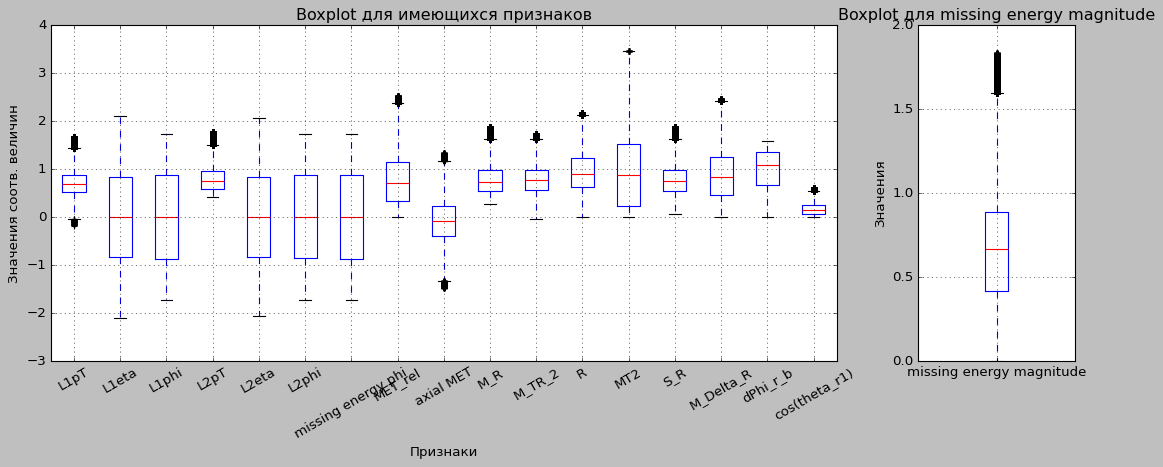

In [17]:
cols = list(X_clean.columns.copy())
cols.remove('missing energy magnitude')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6),
                              gridspec_kw={'width_ratios': [5, 1]})

X_clean.boxplot(column=cols, ax=ax1, rot=30)
ax1.set_xlabel('Признаки')
ax1.set_ylabel('Значения соотв. величин')
ax1.set_title('Boxplot для имеющихся признаков')

X_clean.boxplot(column=['missing energy magnitude'], ax=ax2, rot=0)
ax2.set_title('Boxplot для missing energy magnitude')
ax2.set_ylabel('Значения')

plt.tight_layout()
plt.show()

Из-за перераспределения значений признаков появились новые выбросы, но они уже выглядят не так страшно.

Итого: датафрейм X_clean содержит исходные признаки, выбросы при этом заменены на медиану, а пропуски заполнены с помощью линейной регрессии по признакам без пропусков.

#### 3. Обучение моделей

In [19]:
print(f'Всего класса 1 {y.sum()} шт., класса 0 {y.count() - y.sum()} шт.')

Всего класса 1 54185.0 шт., класса 0 245815.0 шт.


In [20]:
#для теста используйте 30% выборки, размер валидационной выборки выберите на ваше усмотрение
X_train, X_valid, y_train, y_valid = train_test_split(
    X_clean, y,
    test_size=0.3,
    random_state=0,
    shuffle=True,
    stratify=y
)

У нас есть дисбаланс классов, поэтому используем StratifiedSplit для разделения данных на выборки.

Найдём число доступных ядер, чтобы проводить параллельные вычисления:

In [21]:
n_cpus = multiprocessing.cpu_count()
n_cpus

8

Будем для каждого из классификаторов проводить поиск оптимальных гиперпараметров, используя стратегию кросс-валидации. При этом словари параметров выбраны исходя из некоторого прошлого опыта и предыдущих попыток решить эту же задачу, а также с учётом ограниченного времени выполнения задачи.

##### DecisionTreeClassifier

In [26]:
# словарь параметров
parameters_grid = {
    'max_depth' : np.arange(30, 50, 5),
    'min_samples_split' : np.arange(2, 100, 30),
    'min_samples_leaf' : np.arange(5, 16, 5),
    'max_features' : np.arange(10, 19, 3)
}

# задаем стратегию кросс-валидации
cv_strategy = StratifiedKFold(
    n_splits=5,
    shuffle=True
)

# задаем имя метрики для максимизации, str
scorer_name = 'f1'

# задаем модель
model = DecisionTreeClassifier()

# определяем поиск по сетке
search = GridSearchCV(
    # модель для обучения
    estimator=model,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, можно задать строкой
    scoring=scorer_name,
    # GridSearchCV, RandomizedSearchCV отлично параллелятся на несколько ядер
    # n_jobs=-1 означает, что мы используем все доступные ядра
    n_jobs=1,
    # стратегия кросс-валидации
    cv=cv_strategy,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [27]:
%%time
# выполняем поиск по сетке
search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5; 1/144] START max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2
[CV 1/5; 1/144] END max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2;, score=0.621 total time=   7.0s
[CV 2/5; 1/144] START max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2
[CV 2/5; 1/144] END max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2;, score=0.625 total time=   7.2s
[CV 3/5; 1/144] START max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2
[CV 3/5; 1/144] END max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2;, score=0.635 total time=   7.6s
[CV 4/5; 1/144] START max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2
[CV 4/5; 1/144] END max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2;, score=0.616 total time=   7.1s
[CV 5/5; 1/144] START max_depth=30, max_features=10, min_samples_leaf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise', estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'max_depth': array([30, 35, 40, 45]),
                         'max_features': array([10, 13, 16]),
                         'min_samples_leaf': array([ 5, 10, 15]),
                         'min_samples_split': array([ 2, 32, 62, 92])},
             scoring='f1', verbose=10)

In [28]:
search.best_params_

{'max_depth': np.int64(45),
 'max_features': np.int64(16),
 'min_samples_leaf': np.int64(15),
 'min_samples_split': np.int64(62)}

In [29]:
y_predicted = search.predict(X_valid)
print(f'F1 score = {(f1_score(y_valid, y_predicted)):.4f}')

F1 score = 0.6491


**Выводы:** Не очень хорошее получилось значение метрики, можно было бы ещё раз запустить для значений в окрестностях search.best_params_, но очень долго считается.

##### LogisticRegression

Логистическая регрессия и kNN чувствительны к масштабу признаков, поэтому проведём стандартизацию. Также будем использовать сбалансированные веса классов, т.к. у нас сильный дисбаланс внутри данных. Попробуем сразу брать регрессию с регуляризацией, т.к. учитывая корреляцию между некоторыми признаками, можно предположить, что обычная регрессия не даст ничего хорошего.n_jobs приходится использовать 1, т.к. только таким образом видно логи.

In [32]:
pipeline1 = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("regressor", LogisticRegression()),  # final estimator is a classifier
    ]
)
pipeline1.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'scaler', 'regressor', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'regressor__C', 'regressor__class_weight', 'regressor__dual', 'regressor__fit_intercept', 'regressor__intercept_scaling', 'regressor__l1_ratio', 'regressor__max_iter', 'regressor__multi_class', 'regressor__n_jobs', 'regressor__penalty', 'regressor__random_state', 'regressor__solver', 'regressor__tol', 'regressor__verbose', 'regressor__warm_start'])

In [35]:
# словарь параметров
parameters_grid = {
    'regressor__penalty' : ['l1', 'l2'],
    'regressor__C' : np.logspace(-4, 3, 30),
    'regressor__solver' : ['saga'],
    'regressor__class_weight' : ['balanced']
}

# задаем стратегию кросс-валидации
cv_strategy = StratifiedKFold(
    n_splits=5,
    shuffle=True
)

# задаем имя метрики для максимизации, str
scorer_name = 'f1'

# задаем модель
model = pipeline1

# определяем поиск по сетке
search2 = GridSearchCV(
    # модель для обучения
    estimator=model,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, можно задать строкой
    scoring=scorer_name,
    # GridSearchCV, RandomizedSearchCV отлично параллелятся на несколько ядер
    # n_jobs=-1 означает, что мы используем все доступные ядра
    n_jobs=1,
    # стратегия кросс-валидации
    cv=cv_strategy,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [36]:
%%time
# выполняем поиск по сетке
search2.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5; 1/60] START regressor__C=0.0001, regressor__class_weight=balanced, regressor__penalty=l1, regressor__solver=saga
[CV 1/5; 1/60] END regressor__C=0.0001, regressor__class_weight=balanced, regressor__penalty=l1, regressor__solver=saga;, score=0.457 total time=   2.1s
[CV 2/5; 1/60] START regressor__C=0.0001, regressor__class_weight=balanced, regressor__penalty=l1, regressor__solver=saga
[CV 2/5; 1/60] END regressor__C=0.0001, regressor__class_weight=balanced, regressor__penalty=l1, regressor__solver=saga;, score=0.456 total time=   2.0s
[CV 3/5; 1/60] START regressor__C=0.0001, regressor__class_weight=balanced, regressor__penalty=l1, regressor__solver=saga
[CV 3/5; 1/60] END regressor__C=0.0001, regressor__class_weight=balanced, regressor__penalty=l1, regressor__solver=saga;, score=0.456 total time=   2.9s
[CV 4/5; 1/60] START regressor__C=0.0001, regressor__class_weight=balanced, regressor__penalty=l1, regressor__sol

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', LogisticRegression())]),
             n_jobs=1,
             param_grid={'regressor__C': array([1.00000000e-04, 1.74332882e-04, 3.03919538e-04, 5.29831691e-04,
       9.23670857e-04, 1.61026203e-03, 2.80721620e-03, 4.89390092e-03,
       8...
       7.88046282e-02, 1.37382380e-01, 2.39502662e-01, 4.17531894e-01,
       7.27895384e-01, 1.26896100e+00, 2.21221629e+00, 3.85662042e+00,
       6.72335754e+00, 1.17210230e+01, 2.04335972e+01, 3.56224789e+01,
       6.21016942e+01, 1.08263673e+02, 1.88739182e+02, 3.29034456e+02,
       5.73615251e+02, 1.00000000e+03]),
                         'regressor__class_weight': ['balanced'],
                         'regressor__penalty': ['l1', 'l2'],
                         'regressor__solver': ['saga']},
             scoring='f1', verbose=10)

In [37]:
y_predicted2 = search2.predict(X_valid)
print(f'F1 score = {(f1_score(y_valid, y_predicted2)):.4f}')
print(f'Acc. score = {(accuracy_score(y_valid, y_predicted2)):.4f}')

F1 score = 0.4917
Acc. score = 0.7394


**Выводы:** Метрика получилась хуже, чем на дереве. Возможно, связано с тем, что много возможных значений, а всего перебирается наборов значений параметров не так много, т.к. работает gridsearchCV долго, поэтому, большая вероятность, что в минимум за это ограниченное время попасть не удалось. А может быть,  данные просто плохо описываются линейной моделью.

##### KNeighborsClassifier

Аналогично, будем использовать стандартизацию перед классификацией.

In [38]:
pipeline2 = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("classifier", KNeighborsClassifier()),  # final estimator is a classifier
    ]
)
pipeline2.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'scaler', 'classifier', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'classifier__algorithm', 'classifier__leaf_size', 'classifier__metric', 'classifier__metric_params', 'classifier__n_jobs', 'classifier__n_neighbors', 'classifier__p', 'classifier__weights'])

In [42]:
# словарь параметров
parameters_grid = {
    'classifier__n_neighbors' : np.arange(1, 51, 2),
    'classifier__n_jobs' : [-1]
}

# задаем стратегию кросс-валидации
cv_strategy = StratifiedKFold(
    n_splits=5,
    shuffle=True
)

# задаем имя метрики для максимизации, str
scorer_name = 'f1'

# задаем модель
model = pipeline2

# определяем поиск по сетке
search3 = GridSearchCV(
    # модель для обучения
    estimator=model,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, можно задать строкой
    scoring=scorer_name,
    # GridSearchCV, RandomizedSearchCV отлично параллелятся на несколько ядер
    # n_jobs=-1 означает, что мы используем все доступные ядра
    n_jobs=1,
    # стратегия кросс-валидации
    cv=cv_strategy,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [43]:
%%time
# выполняем поиск по сетке
search3.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START classifier__n_jobs=-1, classifier__n_neighbors=1...........
[CV 1/5; 1/25] END classifier__n_jobs=-1, classifier__n_neighbors=1;, score=0.542 total time=  17.7s
[CV 2/5; 1/25] START classifier__n_jobs=-1, classifier__n_neighbors=1...........
[CV 2/5; 1/25] END classifier__n_jobs=-1, classifier__n_neighbors=1;, score=0.546 total time=  16.4s
[CV 3/5; 1/25] START classifier__n_jobs=-1, classifier__n_neighbors=1...........
[CV 3/5; 1/25] END classifier__n_jobs=-1, classifier__n_neighbors=1;, score=0.536 total time=  17.1s
[CV 4/5; 1/25] START classifier__n_jobs=-1, classifier__n_neighbors=1...........
[CV 4/5; 1/25] END classifier__n_jobs=-1, classifier__n_neighbors=1;, score=0.546 total time=  17.6s
[CV 5/5; 1/25] START classifier__n_jobs=-1, classifier__n_neighbors=1...........
[CV 5/5; 1/25] END classifier__n_jobs=-1, classifier__n_neighbors=1;, score=0.547 total time=  16.7s
[CV 1/5; 2/25] START classif

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=1,
             param_grid={'classifier__n_jobs': [-1],
                         'classifier__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
             scoring='f1', verbose=10)

In [45]:
y_predicted3 = search3.predict(X_valid)
print(f'F1 score = {(f1_score(y_valid, y_predicted3)):.4f}')

F1 score = 0.5781


**Выводы:** Метрика лучше, чем у регрессии, но хуже, чем у дерева.

##### RandomForestClassifier

Т.к. лучше всего метрика получилась на дереве, то кажется логичным также проверить случайный лес - скорее всего, на нём метрика будет ещё лучше. Параметры возьмём в окрестности оптимальных для обычного дерева. В мтоге было принято решение проверить только лес с оптимальными параметрами для дерева, т.к. gridsearchcv для леса - это очень долго, а задача учебная.

In [63]:
# словарь параметров
parameters_grid = {
    'max_depth' : [45],
    'min_samples_split' : [62],
    'min_samples_leaf' : [15],
    'max_features' : [16],
    'n_jobs' : [-1]
}

# задаем стратегию кросс-валидации
cv_strategy = StratifiedKFold(
    n_splits=5,
    shuffle=True
)

# задаем имя метрики для максимизации, str
scorer_name = 'f1'

# задаем модель
model4 = RandomForestClassifier()

# определяем поиск по сетке
search4 = GridSearchCV(
    # модель для обучения
    estimator=model4,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, можно задать строкой
    scoring=scorer_name,
    # GridSearchCV, RandomizedSearchCV отлично параллелятся на несколько ядер
    # n_jobs=-1 означает, что мы используем все доступные ядра
    n_jobs=1,
    # стратегия кросс-валидации
    cv=cv_strategy,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [64]:
%%time
# выполняем поиск по сетке
search4.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START max_depth=45, max_features=16, min_samples_leaf=15, min_samples_split=62, n_jobs=-1
[CV 1/5; 1/1] END max_depth=45, max_features=16, min_samples_leaf=15, min_samples_split=62, n_jobs=-1;, score=0.671 total time= 2.5min
[CV 2/5; 1/1] START max_depth=45, max_features=16, min_samples_leaf=15, min_samples_split=62, n_jobs=-1
[CV 2/5; 1/1] END max_depth=45, max_features=16, min_samples_leaf=15, min_samples_split=62, n_jobs=-1;, score=0.673 total time= 2.3min
[CV 3/5; 1/1] START max_depth=45, max_features=16, min_samples_leaf=15, min_samples_split=62, n_jobs=-1
[CV 3/5; 1/1] END max_depth=45, max_features=16, min_samples_leaf=15, min_samples_split=62, n_jobs=-1;, score=0.678 total time= 2.4min
[CV 4/5; 1/1] START max_depth=45, max_features=16, min_samples_leaf=15, min_samples_split=62, n_jobs=-1
[CV 4/5; 1/1] END max_depth=45, max_features=16, min_samples_leaf=15, min_samples_split=62, n_jobs=-1;, score=0.673 tota

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise', estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': [45], 'max_features': [16],
                         'min_samples_leaf': [15], 'min_samples_split': [62],
                         'n_jobs': [-1]},
             scoring='f1', verbose=10)

In [65]:
y_predicted4 = search4.predict(X_valid)
print(f'F1 score = {(f1_score(y_valid, y_predicted4)):.4f}')

F1 score = 0.6804


#### 4. Анализ полученных результатов и выводы по задаче

In [73]:
models = {
    'Decision Tree': y_predicted,
    'Logistic Regression': y_predicted2,
    'KNN': y_predicted3,
    'Random Forest': y_predicted4
}

# Для бинарной классификации собираем более детальные метрики
metrics = []
for name, pred in models.items():
    metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(y_valid, pred),
        'Precision (pos)': precision_score(y_valid, pred),
        'Recall (pos)': recall_score(y_valid, pred),
        'F1 (pos)': f1_score(y_valid, pred),
        'ROC-AUC': roc_auc_score(y_valid, pred)
    })

# Создаем и форматируем таблицу
df_metrics = pd.DataFrame(metrics)
df_metrics.set_index('Model', inplace=True)

styled_df = df_metrics.style \
    .format('{:.2%}', subset=['Accuracy', 'Precision (pos)', 'Recall (pos)', 
                             'F1 (pos)']) \
    .format('{:.3f}', subset=['ROC-AUC']) \
    .background_gradient(cmap='Blues') \
    .set_caption('Сравнение моделей')

styled_df

,Accuracy,Precision (pos),Recall (pos),F1 (pos),ROC-AUC
Model,,,,,
Decision Tree,88.90%,75.65%,56.84%,64.91%,0.764
Logistic Regression,73.94%,37.96%,69.78%,49.17%,0.723
KNN,87.48%,73.87%,47.49%,57.81%,0.719
Random Forest,90.49%,86.60%,56.03%,68.04%,0.771


**Выводы:** Наилучшая метрика F1 (требуется по условию задачи) на валидации получилась у дерева и случайного леса, а наихудшая у регрессии. Из этого можно предположить, что зависимость мы ищем нелинейную. Также по значению метрики можно сделать вывод, что полученная модель не очень хорошая, хотелось бы лучше. Это может быть связано с тем, что:

1. выбранные для поиска оптимальных значения гиперпараметров были неудачными

2. шаг параметров для gridsearchcv был большим и оптимизатор не попал в искомый минимум

3. можно было бы попробовать другие стратегии обработки выбросов и пропусков, может быть, результат был бы лучше.

Тем не менее, модель предсказывает какой-то процент значений верно, а значит, это уже путь к успеху!